# Classification exercise in HEP

The aim of this notebook is to show an implementation in python of a simple LHC data analysis, seen as a classification task to handle with machine learning tools.  
It is inspired by the work shown in Baldi et al. (https://arxiv.org/abs/1402.4735), and it uses as data samples the ones accompanying that paper, and available as

https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz

and 

https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz.


The accompanying slides give some more information about the LHC and the addressed physical problem, the following notes are meant to make the notebook self-sufficient. Most of the material about the parameters of the neural network is tacitly taken from the tutorial https://arxiv.org/abs/1803.08823, which is a tutorial with lots of hnds-on notebook which I strongly recommend. Some material is also taken from the site, https://machinelearningmastery.com/, which is where I often find very clear answers when I ask myself the question: 'how do I do this?'.

## Definition of the physics problem

Each of the samples includes a large sample of simulated LHC events, chracterised by a well defined final state. For the HIGGS sample the final state is two jets coming from the fragmentation of two b-quarks, and the decay products of two W bosons.  If we adress the case where one of the W decays into a lepton and a neutrino, and the other decays into two jets, we  have four jets, 1 lepton and the measured imbalance of the momentum in the plane. For each of the jets/lepton the 4-momentum is stored in the datafiles, in the standard coordinate system used in collider experiments, and the two components on the of the tranverse momentum imbalance (MET), which represent a measurement of the two transverse components of the momentum of the neutrino which escapes detection.

Each event has a label 0 or 1, which will be named SIG, where 1 means that the event is a SIGNAL event, i.e. it was produced by the physical process we are trying to discover, and 0 means that the event is a BACKGROUND i.e. was produced by a known process, and we want to discard it. Our task is, based on the the information for each event which we have in the  datafiles. 

To be more specific, the signal events are diagrammatically represented as

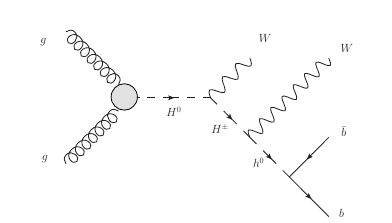

while the background events are represented as.

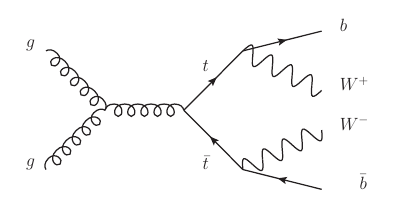

Besides the low-level features which fully describe the event, high level features can be built which incorporate our knowledge  of the kinematics of the heavy particles whose decay products are observed in the detector. In our case the invariant mass of different jet combinations can help to distinguish signal from the background.

The interest of looking at two different analyses is that the SUSY classification task is comparatively easy, with clear discriminants, while the HIGGS sample is much more difficult, and the behaviour of the different ML algorithms for classification is very different in the two cases, thus allowing to show different features.
The notebook is set up in such way that setting the 'higgsusy' flag in the first program cell  to 1 loads the SUSY sample, and to 2 loads the HIGGS sample.  The comments in the notebook are adapted to the HIGGS case, but the code will run correctly on both samples

The aim of the exercise is to create a classifier which optimally separates the events with SIG=1 out of the events with SIG=0

We start with loading the data fron the csv files into panda dataframes, where each row represents an event, and each column a feature. 

In the interest of speed both of loading and processing the large original data samples, of several million events are reduced to 240k. The student is encouraged to try out the full samples, and to try to reproduce on the basis of the code given below the results of Baldi et al.

In [ ]:
#Load the dataset using pandas and numpy

import pandas as pd
import numpy as np
import gzip


higgsusy=2

print("higgsusy switch ",higgsusy)

if higgsusy==1:

  link='https://www.dropbox.com/s/muyqdaw17iqxlnd/susyred1.csv.gz?dl=1' 


  features=['SIG','lep_1_pT', 'lep_1_eta', 'lep_1_phi', 'lep_2_pT', 'lep_2_eta', 'lep_2_phi',
            'MET_val', 'MET_phi', 'MET_rel', 'axial_MET',  'MT2']        

  low_features=['lep_1_pT', 'lep_1_eta', 'lep_1_phi', 'lep_2_pT', 'lep_2_eta', 'lep_2_phi',
                'MET_val', 'MET_phi']

  high_features=['MET_rel', 'axial_MET', 'MT2']
                  
if higgsusy==2:

  link='https://www.dropbox.com/s/vdnstm4qo24uppn/higgsred.csv.gz?dl=1'
  
  features=['SIG','lepton_pT', 'lepton_eta', 'lepton_phi', 'MET_val', 'MET_phi', 
            'jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_btag', 'jet2_pt', 'jet2_eta', 'jet2_phi', 'jet2_btag', 
            'jet3_pt', 'jet3_eta', 'jet3_phi', 'jet3_btag', 'jet4_pt', 'jet4_eta', 'jet4_phi', 'jet4_btag', 
            'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']

  low_features=['lepton_pT', 'lepton_eta', 'lepton_phi', 'MET_val', 'MET_phi', 
            'jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_btag', 'jet2_pt', 'jet2_eta', 'jet2_phi', 'jet2_btag', 
            'jet3_pt', 'jet3_eta', 'jet3_phi', 'jet3_btag', 'jet4_pt', 'jet4_eta', 'jet4_phi', 'jet4_btag']

  high_features=['m_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']

# define number of records that we want to read
N = 240000
print("Size of dataset : %i"%N)
df = pd.read_csv(link, compression='gzip', header=None,nrows=N,engine='python')
#Name the columns using the 'features' array
df.columns=features
#Inspect contents
print(df.head)


## Visual inspection of data

We compare the distributions of variables for signal and background. A convenient library 
for data visualistion built on top of maptlotlib providing various different way of studying the correlations among features is seaborn https://seaborn.pydata.org/

First compare the low level variables one by one using the <i>histplot</i> function and arrange them neatly 
in row and columns


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Look at variables: first basic kinematics
nrow = int(len(low_features)/3)
print(nrow)
print 
if(len(low_features)%3>0):
  nrow=nrow+1
if nrow==0:
  nrow=1;
fig, axes = plt.subplots(nrow,3  , figsize=(14, 3.5*nrow))
for ii in range (0, len(low_features)):
  idf=ii
  i1=int(ii/3)
  i2=ii%3
  sns.histplot( df, ax=axes[i1,i2], x=low_features[idf], hue="SIG",element="step")
plt.show()

The coordinate system adopted is the standard one for colliders,

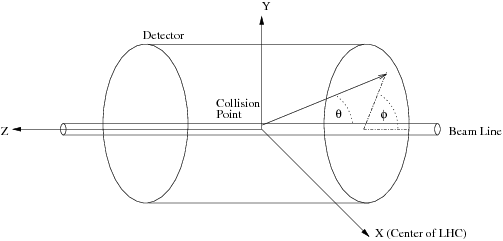

which projected in the xy and xz planes gives

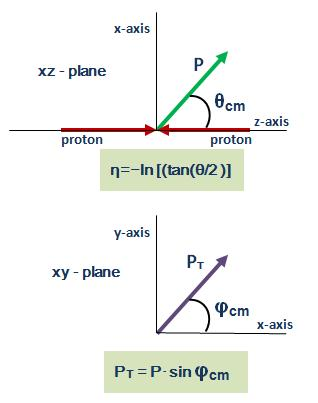

The values of the transverse momenta are not the physical ones, which would be typical in the range of a few tens of GeV, but have been already renormalised in the available data files so that the each distribution is peaked at approximately 1. The reason for this is that the optimisation algorithms of the NN perform badly if the variables in input have wildly different scales.  Normally the analyser should take care to perform this normalisation. 

The phi distributions are completely flat, because of the axial geometry of a collider experiment at the LHC. 
There is however information in the difference in azimuthal angle between the different particles. To eliminate this degree of freedom, and make the task easier for the algorithms, 
one typically rotates each event in such a way that MET_phi=0, and thus the azimuthal angle of the leptons 
is the difference w.r.t. the azimuthal angle of the MET. This has not been done in this case.

The eta distribution is limited to +-2.5 for leptons and +-3 for jets, determined by the the geometry of the detector, and by the fact that heavy particles are produced centrally, i.e. the largest component of the momentum is typically perpendicular to the beam line.

The btag variable tells whether the jet is ftom the fragmentation of a gluon, of a light quark, or a b-quark.  

None of the low level variables seems to have a signal with strikingly different shape from the background

Lets look now at the high level features 

In [ ]:
nrow = int(len(high_features)/3)
if(len(high_features)%3>0):
   nrow=nrow+1
if(nrow==0):
   nrow=1
fig, axes = plt.subplots(nrow, 3  , figsize=(14, 3.5*nrow)) 
for ii in range (0, len(high_features)):
  idf=ii
  i1=int(ii/3)
  i2=ii%3
  if(nrow>1):
    sns.histplot( df, ax=axes[i1,i2], x=high_features[idf], hue="SIG",element="step")
  if(nrow==1):
    sns.histplot( df, ax=axes[i2], x=high_features[idf], hue="SIG",element="step")
plt.show()

Given a particle A decaying into two particles B and C, the mass of the original particle A (mA)can be reconstructed fron the 4-momenta A and B based on the formula

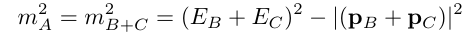

![image.png](attachment:image.png)

where E is the energy and <b>p</b> is the 4-momentum of each particle
For the signal each of the mass combination should peak at as specific value:

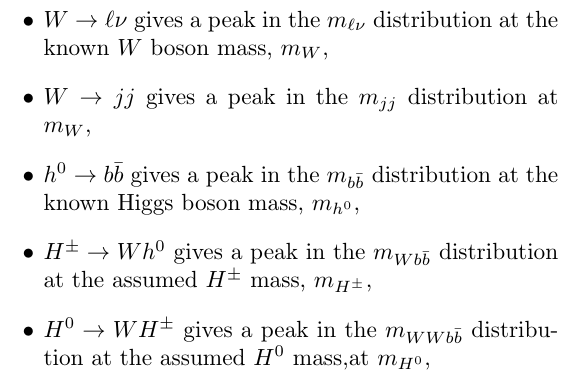

wheras for the background

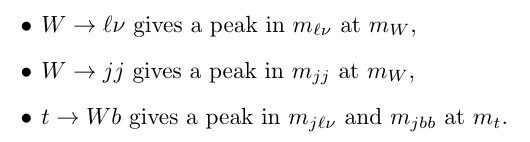

Thus, when combined yielding a good separation power between signal and background.

As for the low level variables, the actual position of the peaks in the plot have all been scaled in such a way that the peak is at ~1. In GeV for the signal mjj it should peak at 80, mbb at 125 mwbb at 325 and mwwbb at 425 which are respectively the masses of W, SM higgs, H+ and H0.  

For the high level features  which seem to provide the best separation power we can plot  all of the pairwise correlations using the <i>pairplot</i> or the <i>PairGrid</i> function of seaborn.
https://seaborn.pydata.org/generated/seaborn.pairplot.html
In order to make the correlation better visible we load a much smaller sample of data 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df1 = pd.read_csv(link, compression='gzip', header=None,nrows=5000,engine='python')
df1.columns=features
g = sns.pairplot(df1, vars=["m_bb", "m_wbb","m_wwbb"], hue="SIG",height=5, kind='hist')
#g = sns.PairGrid(df1, vars=["MET_val", "MET_rel","axial_MET"], hue="SIG",height=5)
#g.map_diag(sns.histplot)
#g.map_offdiag(sns.scatterplot, s=20)
g.add_legend()


Since there is not a good separation in the 2-d space between signal and background, the 2-d plots are not very informative. We will look later at 2-d side-by sige to get abetter idea

It is not obvious on the basis of these variables to design 'by hand' a series of requirements on the features which will allow a good data-background separation. We will anyway, exploiting the selection method 'query' of dataframe try to develop a cut and count selection, to have a reference point with which to compare the ML results.

We will later show in detail how to estimate the performance of the selection, we will simply use here as a metric  the ratio of the efficiency for signal to the efficiency for background of a given set of cuts.


In [ ]:

import math
from math import sqrt

# define one dataframe containing only the signal events and one containing only the background events
df_bkg=df.query('SIG==0')
df_sig=df.query('SIG==1')
# apply a selection on variables
cut='m_bb>0.'
df_sel_sig = df_sig.query(cut)
df_sel_bkg = df_bkg.query(cut)
# calculate and print the efficency of the selection

effsig=df_sel_sig.shape[0]/df_sig.shape[0]
effbkg=df_sel_bkg.shape[0]/df_bkg.shape[0]
if(effbkg>0):
  effrat=effsig/effbkg

print('effsig ',effsig)
print('effbkg ',effbkg)
print('effrat ',effrat)

# plot a variable of interest after applying cuts superimposing signal and background
# to evaluate whether any additional discrimination is possible
bins = np.linspace(0.,3,100)
plt.hist(df_sel_bkg.m_bb, bins, alpha=0.5, density=True, label='Background')
plt.hist(df_sel_sig.m_bb, bins, alpha=0.5, density=True, label='Signal')
plt.legend(loc='best')
plt.show()





For the more adventurous, one can also plot 2-dimensional correlations for the variables, 

In [ ]:
def plot_2d(df, sel1, sel2, var1, var2, nbx, blx, bhx, nby, bly, bhy):
  df_pass = df.query(sel1)
  df_nopass = df.query(sel2) 
  binsx = np.linspace(blx, bhx, nbx)
  binsy = np.linspace(bly, bhy, nby)
  fig= plt.figure(figsize=(14,5))
  plt.subplot(1, 2,1)
  plt.hist2d(df_nopass[var1], df_nopass[var2], bins=[binsx, binsy], density=False, cmin=0.5)
  plt.title(sel2)
  plt.xlabel(var1)
  plt.ylabel(var2)
  plt.subplot(1, 2,2)
  plt.hist2d(df_pass[var1], df_pass[var2], bins=[binsx,binsy],  density=False, cmin=0.5)
  plt.title(sel1)
  plt.xlabel(var1)
  plt.ylabel(var2)
  plt.show()

sel1='m_bb>0 and SIG==0'
sel2='m_bb>0 and SIG==1'
plot_2d(df, sel1, sel2, 'm_bb', 'm_wbb', 50, 0., 2, 50, 0.5, 2)

<b>Exercise:</b>

1) For the HIGGS sample decide from inspection of the seaborne plots for high level variables which are the 
   most discriminant
   
2) Iterate on those variables with the 'query' method  define a set of selections that optimize  effsig/effbkg

3)  Set  higgsusy=1 in the first cell and perform the same exercise for the SUSY sample

## Preview: Logistic Regression

As an appetizer for the next module, we build a classifier called Logistic Regression which calculates the probabilty for a given event being a signal or a background as the linear weighted sum of the input features mapped to a sigmoidal shape. This is the basic building block for a feed-forward neural network.
In the next lecture we will investigate the parameters 

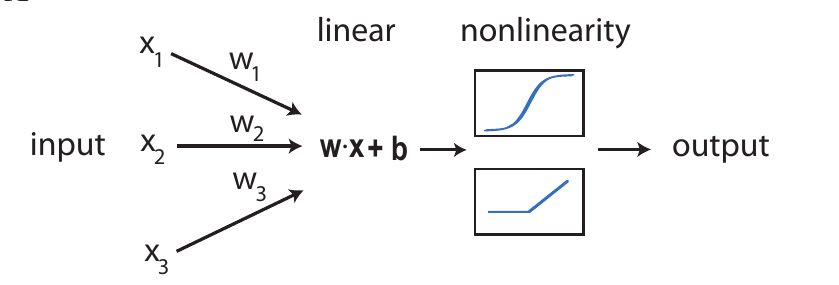

The optimal values for the weights is is obtained through a numerical optimisation procedure.  

In [ ]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import warnings
#Define vectors for input to NN 

# Use first column as definition of target
y = df['SIG'].values

X = df[[col for col in df.columns if col!="SIG"]]
X_low=X[low_features]

# create test and train samples for both full feature set, and low level features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

varnum=X_train.shape[1]
model = keras.Sequential()
model.add(keras.layers.Dense(1, input_dim=varnum, activation='sigmoid'))
model.summary()

opt = keras.optimizers.SGD(learning_rate=0.5)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
print('Training -----------')
model.fit(X_train, y_train, batch_size=100, epochs=50)
Ypred=model.predict(X_test)

Now lets calculate for this the ratio of efficiencies as a function of the probability in output of the classifier

In [ ]:
df_acc = pd.DataFrame({'PROB':Ypred[:,0]})
df_acc['SIG']=y_test

# split according to the label
df_acc_bkg = df_acc.query('SIG==0')
df_acc_sig = df_acc.query('SIG==1')
print('nsig ',df_acc_sig.shape[0])
print('nbkg ',df_acc_bkg.shape[0])

bins = np.linspace(0, 1,50)
for i in range(0,50):
  bb=str(bins[i])
  nsigc=df_acc_sig.query('PROB>'+bb).shape[0]
  nbkgc=df_acc_bkg.query('PROB>'+bb).shape[0]
  effs=nsigc/df_acc_sig.shape[0]
  effb=nbkgc/df_acc_bkg.shape[0] 
  
  if(effb>0):
    effrat=effs/effb
  print ('cut %3.4f' % bins[i],' effs %3.4f ' % effs, ' effb %3.4f' % effb,' effrat %3.4f' % effrat)
         

The best value obtained is similar to the best one obtained with a cut and count analysis, but at the price of a very low efficiency on signal, only a few per mille. We will see that changes drastically by adding a single hidden layer to the algorithm